# 1. Install Dependencies and Setup

In [1]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [3]:
!pip list

Package                               Version
------------------------------------- -------------------
absl-py                               1.4.0
absolufy-imports                      0.3.1
accelerate                            1.10.1
aiofiles                              24.1.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.13.0
aiosignal                             1.4.0
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.8
ale-py                                0.11.2
alembic                               1.16.5
altair                                5.5.0
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.11.0
anywidget                             0.9.18
argon2-cffi                           25.1.0
argon2-cffi-bindings                  25.1.0
array_record                          0.8.1
arrow 

In [4]:
import tensorflow as tf
import os

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Remove dodgy images

In [7]:
import cv2
import imghdr

/tmp/ipython-input-4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [8]:
data_dir = 'data'

In [9]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [11]:
!apt-get install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [12]:
!unrar x data.rar data/


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from data.rar

Creating    data                                                      OK
Creating    data/data                                                 OK
Creating    data/data/happy                                           OK
Extracting  data/data/happy/05-12-21-happy-people.jpg                      0%  OK 
Extracting  data/data/happy/07-120104-happy_people_are_not_nice_people.jpg       0%  OK 
Extracting  data/data/happy/1-2.jpg                                        0%  OK 
Extracting  data/data/happy/1000_F_42220133_toAU6USGY9jVr2XJFLssfG00cSYIJ173.jpg       0%  OK 
Extracting  data/data/happy/11-Habits-of-Truly-Happy-People.jpg            0%  OK 
Extracting  data/data/happy/154006829.jpg                                  2%  3%  5%  6%  8%  9% 11% 12% 14% 15% 16%  OK 
Extracting  data/data/happy/1

In [13]:
!ls data

data


In [14]:
data_dir = '/content/data'

In [15]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Issue with image /content/data/data/sad
Issue with image /content/data/data/happy


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 3. Load Data

In [17]:
import numpy as np
from matplotlib import pyplot as plt

In [18]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 1 classes.


In [19]:
data_iterator = data.as_numpy_iterator()

In [20]:
batch = data_iterator.next()

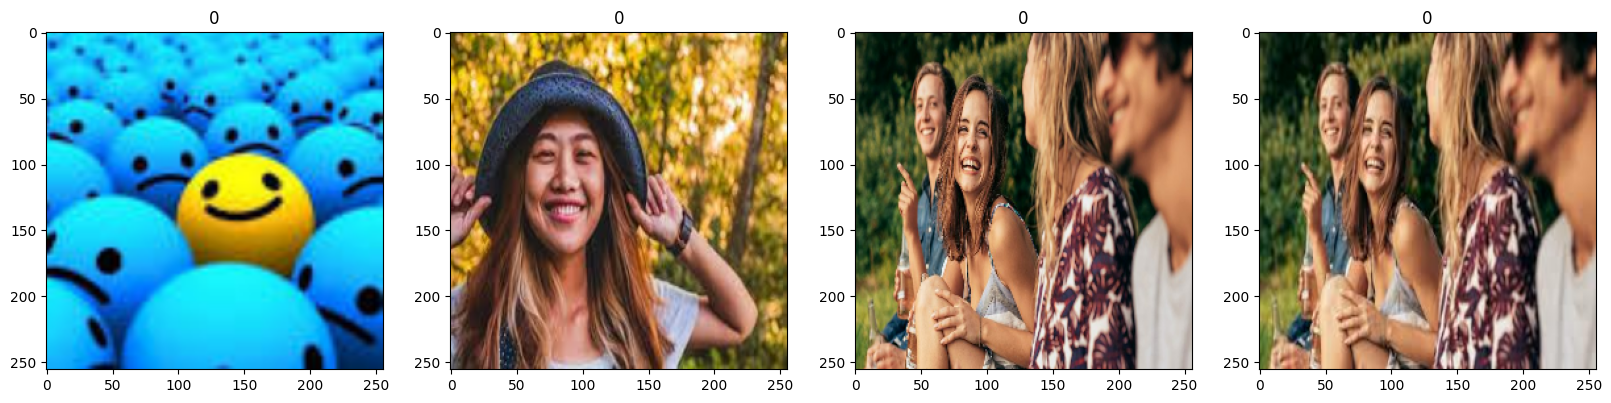

In [21]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [22]:
data = data.map(lambda x,y: (x/255, y))

In [23]:
data.as_numpy_iterator().next()

(array([[[[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         [[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         [[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         ...,
 
         [[1.        , 1.        , 0.97719824],
          [0.99441

# 5. Split Data

In [24]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [25]:
train_size

7

In [26]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [27]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [29]:
model = Sequential()

In [30]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [33]:
logdir='logs'

In [34]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [35]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 513ms/step - accuracy: 0.6580 - loss: 0.3014 - val_accuracy: 1.0000 - val_loss: 1.9477e-06
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 615ms/step - accuracy: 1.0000 - loss: 1.6147e-06 - val_accuracy: 1.0000 - val_loss: 3.3549e-10
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 735ms/step - accuracy: 1.0000 - loss: 6.3205e-10 - val_accuracy: 1.0000 - val_loss: 6.2810e-11
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 568ms/step - accuracy: 1.0000 - loss: 9.9469e-11 - val_accuracy: 1.0000 - val_loss: 3.5607e-13
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 600ms/step - accuracy: 1.0000 - loss: 4.0998e-12 - val_accuracy: 1.0000 - val_loss: 5.2933e-12
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 783ms/step - accuracy: 1.0000 - loss: 9.2140e-14 - val_accuracy: 1.0000 - val_loss: 3.7507e-12
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 599ms/step - accuracy: 1.0000 - loss: 1.8462e-13 - val_accuracy: 1.0000 - val_loss: 2.5651e-12
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 593ms/step - accuracy: 1.0

In [70]:
def show_random_prediction(model, data_dir):
    import random, os, cv2, numpy as np, matplotlib.pyplot as plt

    class_names = os.listdir(data_dir)  # auto-detect subfolders
    category = random.choice(class_names)
    img_name = random.choice(os.listdir(os.path.join(data_dir, category)))
    img_path = os.path.join(data_dir, category, img_name)

    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(img_rgb, (256, 256))
    pred = model.predict(np.expand_dims(resized, axis=0))[0][0]

    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"Prediction: {'Happy' if pred > 0.5 else 'Sad'} | Actual: {category}")
    plt.show()

# 8. Plot Performance

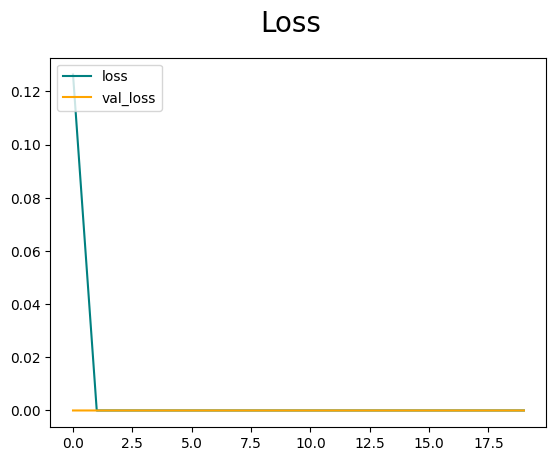

In [36]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

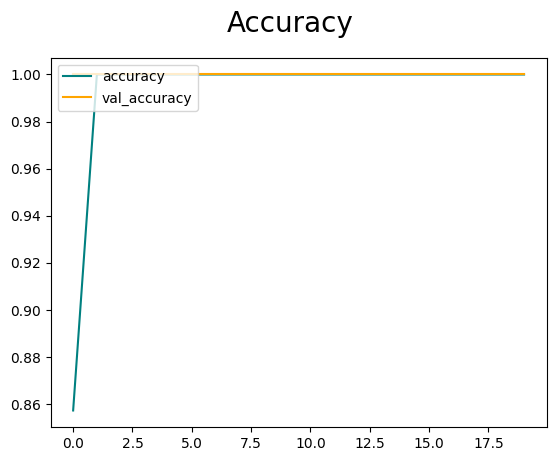

In [37]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [38]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [39]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [40]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step


In [41]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

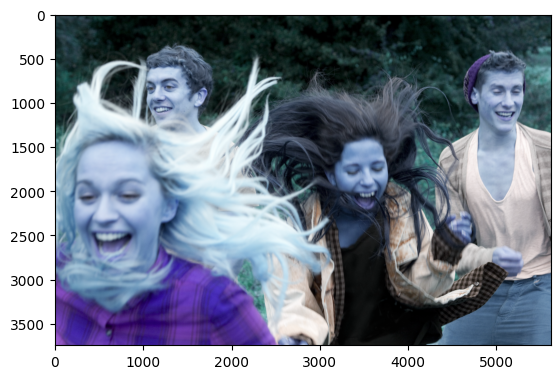

In [51]:
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

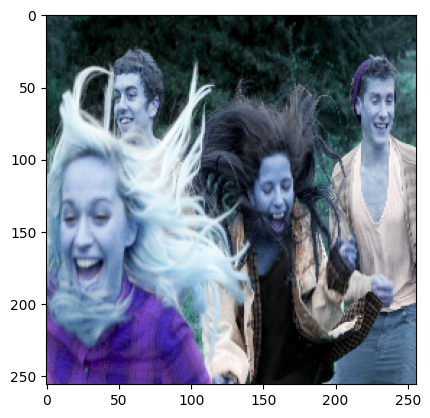

In [52]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [53]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


In [54]:
yhat

array([[2.2245657e-35]], dtype=float32)

In [55]:
if yhat > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [56]:
from tensorflow.keras.models import load_model

In [57]:
model.save(os.path.join('models','imageclassifier.h5'))

In [60]:
from tensorflow.keras.models import load_model
model = load_model('models/imageclassifier.h5')

In [62]:
model.save(os.path.join('models', 'imageclassifier.keras'))